In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
seed = 123
rng = np.random.default_rng(seed)
import scipy.signal as sig

import IPython.display as ipd
import matplotlib.pyplot as plt

import colorednoise as cn

from hr.esm import EsmModel, BlockEsmModel
from hr.preprocess import NoiseWhitening, FilterBank
from hr.process import Esprit, Ester, AdaptiveEsprit, BlockEsprit
from hr.decomp import EsmSubspaceDecomposer
from hr.util import _PINK_FILTRE_COEFFS
from util.util import to_db, snr

# %matplotlib widget
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simple noiseless 'harmonic' signal

In [4]:
sr = 44100
n_s = 100000
n_fft = 1024

# number of sinusoids
r = 8 
# Normalised damping ratios, multiply by sampling rate to get the 'deltas' in Amp.s-1
gammas = rng.uniform(0.001, 0.01, r) 
# Normalised frequencies
nus = rng.normal(0.1, 0.05, r)
amps = rng.uniform(0.1, 1, r)
phis = rng.uniform(0, 2*np.pi, r)

x_esm = EsmModel(gammas, nus, amps, phis)

x_sine = x_esm.synth(n_s)

n_est = 32
p_max = 16
r_est = Ester.estimate_esm_order(x_sine, n_est, p_max)
x_esm_est = Esprit.estimate_esm(x_sine, n_est, r_est)

print(x_esm.nus * sr)
print(x_esm_est.nus * sr)
print(x_esm.gammas * sr)
print(x_esm_est.gammas * sr)
print(x_esm.phis / np.pi)
print(x_esm_est.phis / np.pi)

[1045.32345363 2930.24726624 3699.13199887 3711.90703018 4624.25393767
 4710.5880781  6615.59407035 7038.72625954]
[1045.32345363 2930.24726625 3699.13199772 3711.9070301  4624.25393765
 4710.58807807 6615.59407035 7038.72625954]
[117.27717167 366.42030969  65.46156236 314.92545452 131.5608335
 153.87237849 410.57562972 113.91705214]
[117.27717167 366.42030971  65.46156574 314.92546061 131.56083357
 153.87237846 410.57562972 113.91705214]
[-0.54351334 -0.74893199  0.02978983  0.36867597  0.94226646 -0.2706195
 -0.16575485 -0.16279902]
[-0.54351334 -0.74893199  0.02978987  0.36867597  0.94226646 -0.2706195
 -0.16575485 -0.16279902]


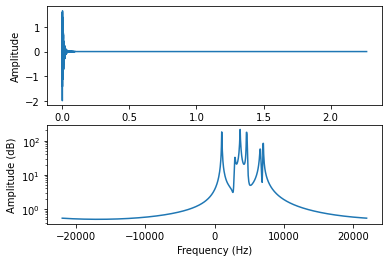

In [5]:
ts_plot = np.arange(n_s) / sr # times in seconds
fs_plot = np.fft.fftfreq(n_fft) * sr

_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
x_sine_ft = np.fft.fft(x_sine, n=n_fft)
plt.title("Time and frequency representation of the synthesised signal")
plt.subplot(2, 1, 1)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.plot(ts_plot, np.real(x_sine))
plt.subplot(2, 1, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_plot), np.fft.fftshift(np.abs(x_sine_ft)))
plt.show()

In [6]:
ipd.Audio(np.real(x_sine), rate=sr)

### Adding noise

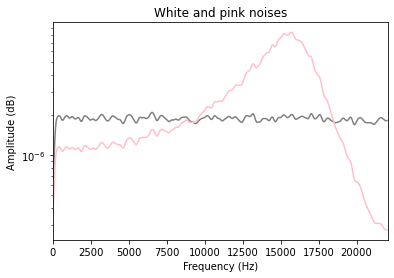

In [7]:
white_noise = rng.random(n_s)
pink_noise = sig.lfilter(_PINK_FILTRE_COEFFS["b"], _PINK_FILTRE_COEFFS["a"], white_noise)

fs_psd, white_noise_psd = sig.welch(white_noise, fs=sr, nfft=n_fft, return_onesided=False)
_, pink_noise_psd = sig.welch(pink_noise, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
plt.title("White and pink noises")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_psd), np.fft.fftshift(white_noise_psd), c='grey')
plt.semilogy(np.fft.fftshift(fs_psd), np.fft.fftshift(pink_noise_psd), c='pink')
plt.xlim(np.array([0, 0.5])*sr)
plt.show()

### Whitening the noise

In [31]:
noise_ratio = 0.01
noise = noise_ratio*pink_noise

x = x_sine + noise
x_snr =snr(np.real(x_sine), noise)
print(f'SNR={x_snr} dB')

SNR=17.79281353987773 dB


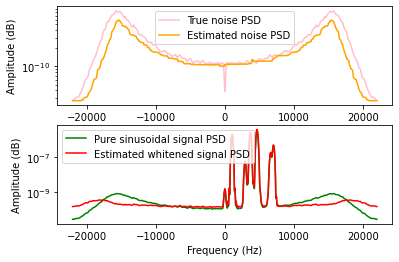

In [32]:
smoothing_factor = 8
quantile_ratio = 0.05
ar_order = 10

# fs_x_psd, x_psd = sig.welch(x, fs=1, nfft=n_fft)
fs_x_psd, x_psd = sig.welch(x, fs=sr, nfft=n_fft, return_onesided=False)
fs_noise_psd, noise_psd = sig.welch(noise, fs=sr, nfft=n_fft, return_onesided=False)

noise_psd_est = NoiseWhitening.estimate_noise_psd(x, fs=sr, n_fft=n_fft, quantile_ratio=quantile_ratio, smoothing_factor=smoothing_factor)
noise_filtre_coeffs_est = NoiseWhitening.estimate_noise_ar_coeffs(noise_psd_est, ar_order=ar_order)
# TODO: compare
# print(_PINK_FILTRE_COEFFS)
# print(noise_filtre_coeffs_est)
x_white, _ = NoiseWhitening.whiten(x, fs=sr, n_fft=n_fft, ar_order=ar_order, quantile_ratio=quantile_ratio, smoothing_factor=smoothing_factor)
_, x_white_psd = sig.welch(x_white, fs=sr, nfft=n_fft, return_onesided=False)
_, x_sine_psd = sig.welch(x_sine, fs=sr, nfft=n_fft, return_onesided=False)

plt.figure()
plt.title("PSD estimation of the noise and whitened signal")
plt.subplot(2, 1, 1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
plt.semilogy(np.fft.fftshift(fs_noise_psd), np.fft.fftshift(noise_psd), c='pink', label="True noise PSD")
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(noise_psd_est), c='orange', label="Estimated noise PSD")
plt.legend()
# plt.xlim(np.array([0, 0.5]) * sr)
plt.subplot(2, 1, 2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude (dB)")
# plt.xlim(np.array([0, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_psd), c='green', label="Pure sinusoidal signal PSD")
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='r', label="Estimated whitened signal PSD")
plt.legend()
plt.show()

In [33]:
ipd.Audio(np.real(x), rate=sr)


### ESM model ordre estimation

#### Does seem to work correctly with the whitened signal!

The whitening process seems to hurt the estimation
of the ESM model ordre with ESTER.
We should use ESTER with the signal whose noise
has not been whitened.

#### Choice of $p_{max}$

According to the article, $p_{max}$ should be 
much lower than $n$.
So according to our expectation on $r$, we should choose
$n$ large enough.

Still unclear, but if $p_{max} > r$
the _a posteriori error bound_ from $E$ 
gives some indication somehow?

In the article:

For each eigenvalue ̂$\hat{z}$ of $\Phi(p)$, 
there is an eigenvalue $z_k$ of $\Phi(r)$ for which:

$$
|\hat{z} − z_k| \leq \kappa_2 ||E(p)||_2
$$ 


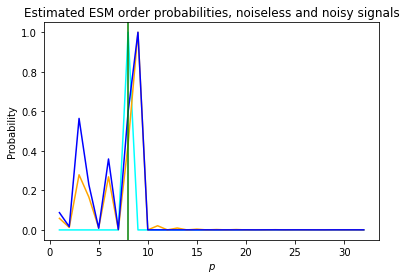

Ordre of the ESM model
Truth=8
Estimated: Noiseless=8, Noisy=9, Whitened=9


In [34]:
n = 128
p_max = 32 # for now
ps = np.arange(1,p_max+1)
j_sine = Ester.inverse_error_func(x_sine, n=n, p_max=p_max)
j_noise = Ester.inverse_error_func(x, n=n, p_max=p_max)
j_white = Ester.inverse_error_func(x_white, n=n, p_max=p_max)

plt.figure()
plt.title('Estimated ESM order probabilities, noiseless and noisy signals')
plt.xlabel('$p$')
plt.ylabel('Probability')
plt.plot(ps, j_sine/np.max(j_sine), c='cyan')
plt.plot(ps, j_noise/np.max(j_noise), c='orange')
plt.plot(ps, j_white/np.max(j_white), c='b')
plt.axvline(r, ymin=0, ymax=1, c='g')
plt.show()

r_est_sine = Ester.estimate_esm_order(x_sine, n, p_max)
r_est_noise = Ester.estimate_esm_order(x, n, p_max)
r_est_white = Ester.estimate_esm_order(x_white, n, p_max)
print('Ordre of the ESM model')
print(f'Truth={r}')
print(f'Estimated: Noiseless={r_est_sine}, Noisy={r_est_noise}, Whitened={r_est_white}')

### Test of the model with whitened signal


We use the ESM model ordre estimated on the 
whitened signal, and apply ESPRIT on
the whitened signal.

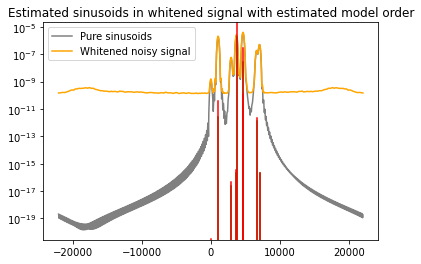

In [69]:
# x_esm_est = Esprit.estimate_esm(x_white, n, r_est_white)
decomp = EsmSubspaceDecomposer(
    fs=sr,
    n_esprit=n,
    p_max_ester=p_max,
    n_fft_noise=n_fft,
    smoothing_factor_noise=smoothing_factor,
    quantile_ratio_noise=quantile_ratio,
    clip_damp=False,
    discard_freq=False,
    correct_alphas=True
)
x_esm_est, x_noise, x_white = decomp.perform(x)


# print(x_esm.nus * sr)
# print(x_esm_est.nus * sr)
# print(x_esm.phis / np.pi)
# print(x_esm_est.phis / np.pi)
# print(x_esm.amps)
# print(x_esm_est.amps)

plt.figure()
plt.title("Estimated sinusoids in whitened signal with estimated model order")
# plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_sine_psd), c='grey', label="Pure sinusoids")
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='orange', label="Whitened noisy signal")
for j in range(len(x_esm.nus)):
    plt.axvline(x_esm.nus[j] * sr, 0, x_esm.amps[j], c='g')
    pass
for j in range(len(x_esm_est.nus)):
    plt.axvline(x_esm_est.nus[j] * sr, 0, x_esm_est.amps[j], c='r')
plt.legend()
plt.show()


In [67]:
x_sine_est = x_esm_est.synth(n_s)
ipd.Audio(np.real(x_sine_est)/np.max(np.abs(x_sine_est)), rate=sr)

In [68]:
# Noise part
ipd.Audio(np.real(x_noise)/np.max(np.abs(x_noise)), rate=sr)

### Filter bank


#### Problem

__What transformation to apply to the estimated frequency in the band $\nu_{i}^b$ to apply to find the estimated frequency $\nu_i^b$?__

$$
\nu_i^b = \frac{\nu_{i,\text{band}}^b}{d} + \nu_c^b
$$

With $\nu_c^b = \frac{b}{N_{bands}}$ the centre frequency for band $b$, $N_{bands}$ the number of bands, and $d$ the decimation factor.

-0.4885629250899722 0.4943606606809658


<Figure size 432x288 with 0 Axes>

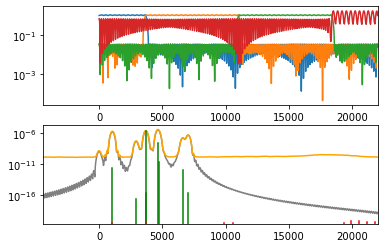

In [70]:
# number of bands
nb_bands = 4
decimation_factor = nb_bands / 2
order_filter = 256
w_trans = 0.01
bank = FilterBank(nb_bands, decimation_factor, order_filter=order_filter, w_trans=w_trans)
x_bands = bank.process(x_white)

clip_damp = True
discard_freq = True

rs_est = []
zs_est = []
alphas_est = []

n_est_fb = 64
p_max_fb = 8
for b in range(bank.nb_bands):
    x_band = x_bands[b]
    r_band = Ester.estimate_esm_order(x_band, n=n_est_fb, p_max=p_max_fb)
    rs_est.append(r_band)
    w_cap, _ = Esprit.subspace_weighting_mats(x_band, n_est, rs_est[b])
    phi_cap = Esprit.spectral_matrix(w_cap)
    zs, _ = Esprit.estimate_poles(phi_cap, clip_damp=clip_damp, discard_freq=discard_freq)
    
    alphas = Esprit.estimate_esm_alphas(x_band, zs)
    # Correct the normalised frequencies
    gammas_est_band, nus_est_band = EsmModel.poles_to_dampfreq(zs)
    # TODO: Not right, fix this
    nus_est_band = nus_est_band/bank.decimation_factor + bank.nus_centre[b]
    zs = EsmModel.dampfreq_to_poles(gammas_est_band, nus_est_band)

    zs_est += zs.tolist()
    alphas_est += alphas.tolist()

# print(nus_est)
# print(nus)
zs_est = np.asarray(zs_est)
alphas_est  = np.asarray(alphas_est)
_, nus_est = EsmModel.poles_to_dampfreq(zs_est)
print(np.amin(nus_est), np.amax(nus_est))
x_esm_est = EsmModel.from_complex(zs_est, alphas_est)
#print(x_esm_est.nus * sr)
#print(x_esm_est.nus * sr)
plt.close("all")
plt.clf()
plt.figure()
plt.title("Estimated sinusoids in whitened signal with estimated model ordre")
plt.subplot(2, 1, 1)
plt.xlim(np.array([-0.1, 0.5])*sr)
for b in range(bank.nb_bands):
    omegas, amps = sig.freqz(bank.filter_coeffs[b], [1])
    nus = omegas / (2 * np.pi)
    plt.semilogy(nus * sr, np.abs(amps))
    # plt.axvline(bank.nus_centre[b] * sr, 0, 1, c='pink')
plt.subplot(2, 1, 2)
plt.xlim(np.array([-0.1, 0.5])*sr)
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_sine_psd), c='grey')
plt.semilogy(np.fft.fftshift(fs_x_psd), np.fft.fftshift(x_white_psd), c='orange')
for j in range(len(x_esm.nus)):
    plt.axvline(x_esm.nus[j] * sr, 0, x_esm.amps[j], c='g')
for j in range(len(x_esm_est.nus)):
    plt.axvline(x_esm_est.nus[j] * sr, 0, x_esm_est.amps[j], c='r')

plt.show()

In [71]:
ipd.Audio(np.real(x)/np.max(np.abs(x)), rate=sr)

In [72]:
x_sine_est = x_esm_est.synth(n_s)
ipd.Audio(np.real(x_sine_est)/np.max(np.abs(x_sine_est)), rate=sr)

### Adaptive ESPRIT

#### Using a custom adaptive ESM

In [ ]:
sr = 4410
n_s = 8000
n_fft = 1024

log_progress = False

nb_blocks = 10
l_block = n_s // nb_blocks
# number of sinusoids
r = 8
# Normalised damping ratios, multiply by sampling rate to get the 'deltas' in Amp.s-1
gammas_list = np.repeat(rng.normal(0.002, 0.0001, (nb_blocks, r)), l_block, axis=0)
# Normalised frequencies
nus_list = np.repeat(rng.normal(0.1, 0.05, (nb_blocks, r)), l_block, axis=0)
amps_list = np.repeat(rng.uniform(0.1, 1, (nb_blocks, r)), l_block, axis=0)
phis_list = np.repeat(rng.uniform(0, 2 * np.pi, (nb_blocks, r)), l_block, axis=0)

x_esm = BlockEsmModel.from_param_lists(
    gammas_list, nus_list, amps_list, phis_list
)

# one sample per value
x_sine = x_esm.synth(1)

n_est = 32
l = 120
x_esm_est = BlockEsprit.estimate_esm(
    x_sine, n_est, r, l, step=50
)

print(x_esm.nus[0] * sr)
print(x_esm_est.nus[0] * sr)
# print(x_esm.gammas * sr)
# print(x_esm_est.gammas * sr)

# x_sine_est = x_esm_est.synth(n_s_block)
